In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb, total_coords))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,3].values # Cd values

In [25]:
y = target_c3.reshape((-1,1))

In [26]:
y.shape

(144, 1)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [28]:
x_train.shape

(100, 113)

In [29]:
y_train.shape

(100, 1)

In [30]:
tf.keras.backend.set_image_data_format('channels_last')

In [31]:
input_data = tf.keras.Input(shape=(3+total_coords.shape[1]))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=16, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 16)                2064      
                                                                 
 outputLayer (Dense)         (None, 1)                 17    

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=500, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [35]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
STEP_SIZE_TEST = len(x_test)//batch_size

In [36]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 2s 5ms/step - loss: 0.0015 - rmse: 0.0388 - lr: 0.0010
Epoch 2/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.4786e-04 - rmse: 0.0187 - lr: 0.0010
Epoch 3/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.8956e-04 - rmse: 0.0138 - lr: 0.0010
Epoch 4/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0865e-04 - rmse: 0.0104 - lr: 0.0010
Epoch 5/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.1045e-05 - rmse: 0.0090 - lr: 0.0010
Epoch 6/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.3334e-05 - rmse: 0.0080 - lr: 0.0010
Epoch 7/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.0870e-05 - rmse: 0.0071 - lr: 0.0010
Epoch 8/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.3677e-05 - rmse: 0.0066 - lr: 0.0010
Epoch 9/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.3621e-05 - rmse: 0.0066 - lr: 0.0010
Epoch

5/5 [==============================] - 0s 4ms/step - loss: 1.8496e-06 - rmse: 0.0014 - lr: 0.0010
Epoch 75/5000
5/5 [==============================] - 0s 3ms/step - loss: 1.6833e-06 - rmse: 0.0013 - lr: 0.0010
Epoch 76/5000
5/5 [==============================] - 0s 3ms/step - loss: 2.7976e-06 - rmse: 0.0017 - lr: 0.0010
Epoch 77/5000
5/5 [==============================] - 0s 3ms/step - loss: 3.8335e-06 - rmse: 0.0020 - lr: 0.0010
Epoch 78/5000
5/5 [==============================] - 0s 3ms/step - loss: 3.3694e-06 - rmse: 0.0018 - lr: 0.0010
Epoch 79/5000
5/5 [==============================] - 0s 3ms/step - loss: 4.0370e-06 - rmse: 0.0020 - lr: 0.0010
Epoch 80/5000
5/5 [==============================] - 0s 3ms/step - loss: 7.0674e-06 - rmse: 0.0027 - lr: 0.0010
Epoch 81/5000
5/5 [==============================] - 0s 3ms/step - loss: 5.8814e-06 - rmse: 0.0024 - lr: 0.0010
Epoch 82/5000
5/5 [==============================] - 0s 3ms/step - loss: 5.0881e-06 - rmse: 0.0023 - lr: 0.0010
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 8.1500e-08 - rmse: 2.8548e-04 - lr: 0.0010
Epoch 146/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.2798e-07 - rmse: 3.5774e-04 - lr: 0.0010
Epoch 147/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.3788e-08 - rmse: 2.8946e-04 - lr: 0.0010
Epoch 148/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.4845e-07 - rmse: 3.8530e-04 - lr: 0.0010
Epoch 149/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.3340e-07 - rmse: 3.6524e-04 - lr: 0.0010
Epoch 150/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.5950e-07 - rmse: 3.9938e-04 - lr: 0.0010
Epoch 151/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.2896e-07 - rmse: 4.7850e-04 - lr: 0.0010
Epoch 152/5000
5/5 [==============================] - 0s 10ms/step - loss: 1.8099e-07 - rmse: 4.2543e-04 - lr: 0.0010
Epoch 153/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.62

5/5 [==============================] - 0s 4ms/step - loss: 2.5369e-08 - rmse: 1.5928e-04 - lr: 0.0010
Epoch 216/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.5215e-08 - rmse: 1.5879e-04 - lr: 0.0010
Epoch 217/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.6712e-08 - rmse: 1.6344e-04 - lr: 0.0010
Epoch 218/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.8434e-08 - rmse: 2.2008e-04 - lr: 0.0010
Epoch 219/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.2277e-08 - rmse: 2.0561e-04 - lr: 0.0010
Epoch 220/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.5350e-08 - rmse: 2.1295e-04 - lr: 0.0010
Epoch 221/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.7933e-08 - rmse: 2.4069e-04 - lr: 0.0010
Epoch 222/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.5124e-08 - rmse: 2.3479e-04 - lr: 0.0010
Epoch 223/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.358

5/5 [==============================] - 0s 4ms/step - loss: 6.5829e-07 - rmse: 8.1135e-04 - lr: 0.0010
Epoch 287/5000
5/5 [==============================] - 0s 4ms/step - loss: 9.1722e-07 - rmse: 9.5772e-04 - lr: 0.0010
Epoch 288/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.4030e-06 - rmse: 0.0012 - lr: 0.0010
Epoch 289/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.1253e-06 - rmse: 0.0011 - lr: 0.0010
Epoch 290/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.7013e-06 - rmse: 0.0016 - lr: 0.0010
Epoch 291/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.0777e-06 - rmse: 0.0014 - lr: 0.0010
Epoch 292/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.1336e-06 - rmse: 0.0015 - lr: 0.0010
Epoch 293/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.3258e-06 - rmse: 0.0015 - lr: 0.0010
Epoch 294/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.8700e-07 - rmse: 8.8713e-04

5/5 [==============================] - 0s 4ms/step - loss: 1.8113e-05 - rmse: 0.0043 - lr: 0.0010
Epoch 358/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.8259e-05 - rmse: 0.0062 - lr: 0.0010
Epoch 359/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.4940e-05 - rmse: 0.0074 - lr: 0.0010
Epoch 360/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.2511e-04 - rmse: 0.0112 - lr: 0.0010
Epoch 361/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.4263e-05 - rmse: 0.0074 - lr: 0.0010
Epoch 362/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.5037e-05 - rmse: 0.0067 - lr: 0.0010
Epoch 363/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.1857e-05 - rmse: 0.0079 - lr: 0.0010
Epoch 364/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.8659e-05 - rmse: 0.0089 - lr: 0.0010
Epoch 365/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.9761e-05 - rmse: 0.0055 - lr: 0.001

5/5 [==============================] - 0s 4ms/step - loss: 4.3183e-07 - rmse: 6.5714e-04 - lr: 0.0010
Epoch 429/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.5772e-07 - rmse: 6.7655e-04 - lr: 0.0010
Epoch 430/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.7319e-07 - rmse: 6.1089e-04 - lr: 0.0010
Epoch 431/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.3627e-07 - rmse: 6.6051e-04 - lr: 0.0010
Epoch 432/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.3174e-07 - rmse: 6.5707e-04 - lr: 0.0010
Epoch 433/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.8655e-07 - rmse: 6.2173e-04 - lr: 0.0010
Epoch 434/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.8257e-07 - rmse: 6.1852e-04 - lr: 0.0010
Epoch 435/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.6991e-07 - rmse: 6.0820e-04 - lr: 0.0010
Epoch 436/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.948

5/5 [==============================] - 0s 4ms/step - loss: 2.1687e-07 - rmse: 4.6569e-04 - lr: 0.0010
Epoch 499/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.9098e-07 - rmse: 4.3701e-04 - lr: 0.0010
Epoch 500/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.5879e-07 - rmse: 5.9899e-04 - lr: 0.0010
Epoch 501/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.5459e-07 - rmse: 5.9548e-04 - lr: 0.0010
Epoch 502/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.8326e-07 - rmse: 6.1908e-04 - lr: 0.0010
Epoch 503/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.3321e-07 - rmse: 4.8292e-04 - lr: 0.0010
Epoch 504/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.4931e-07 - rmse: 5.9102e-04 - lr: 0.0010
Epoch 505/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.4428e-07 - rmse: 5.8675e-04 - lr: 0.0010
Epoch 506/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.001

5/5 [==============================] - 0s 4ms/step - loss: 1.7117e-06 - rmse: 0.0013 - lr: 0.0010
Epoch 570/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.7144e-06 - rmse: 0.0013 - lr: 0.0010
Epoch 571/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0922e-06 - rmse: 0.0010 - lr: 0.0010
Epoch 572/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.5038e-07 - rmse: 7.4188e-04 - lr: 0.0010
Epoch 573/5000
5/5 [==============================] - 0s 6ms/step - loss: 6.1920e-07 - rmse: 7.8689e-04 - lr: 0.0010
Epoch 574/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.4367e-07 - rmse: 8.0229e-04 - lr: 0.0010
Epoch 575/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.3706e-07 - rmse: 7.3284e-04 - lr: 0.0010
Epoch 576/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.0491e-07 - rmse: 8.3959e-04 - lr: 0.0010
Epoch 577/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.7044e-07 - rmse

5/5 [==============================] - 0s 5ms/step - loss: 4.5139e-09 - rmse: 6.7185e-05 - lr: 0.0010
Epoch 640/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.0292e-09 - rmse: 7.0917e-05 - lr: 0.0010
Epoch 641/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.1519e-09 - rmse: 7.1777e-05 - lr: 0.0010
Epoch 642/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.2944e-09 - rmse: 7.2763e-05 - lr: 0.0010
Epoch 643/5000
5/5 [==============================] - 0s 4ms/step - loss: 4.7123e-09 - rmse: 6.8646e-05 - lr: 0.0010
Epoch 644/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.8099e-09 - rmse: 6.1725e-05 - lr: 0.0010
Epoch 645/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.6618e-09 - rmse: 6.0513e-05 - lr: 0.0010
Epoch 646/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.8362e-09 - rmse: 6.1937e-05 - lr: 0.0010
Epoch 647/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.997

5/5 [==============================] - 0s 4ms/step - loss: 6.7432e-10 - rmse: 2.5968e-05 - lr: 5.0000e-04
Epoch 708/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.8691e-10 - rmse: 2.6209e-05 - lr: 5.0000e-04
Epoch 709/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.8578e-10 - rmse: 2.6187e-05 - lr: 5.0000e-04
Epoch 710/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.8983e-10 - rmse: 2.6265e-05 - lr: 5.0000e-04
Epoch 711/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.9211e-10 - rmse: 2.8144e-05 - lr: 5.0000e-04
Epoch 712/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.6526e-10 - rmse: 2.5793e-05 - lr: 5.0000e-04
Epoch 713/5000
5/5 [==============================] - 0s 5ms/step - loss: 7.2776e-10 - rmse: 2.6977e-05 - lr: 5.0000e-04
Epoch 714/5000
5/5 [==============================] - 0s 5ms/step - loss: 6.4051e-10 - rmse: 2.5308e-05 - lr: 5.0000e-04
Epoch 715/5000
5/5 [===========================

Epoch 775/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.5235e-10 - rmse: 2.5541e-05 - lr: 5.0000e-04
Epoch 776/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.6734e-10 - rmse: 2.3819e-05 - lr: 5.0000e-04
Epoch 777/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.4032e-10 - rmse: 2.3245e-05 - lr: 5.0000e-04
Epoch 778/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.0045e-10 - rmse: 1.7333e-05 - lr: 5.0000e-04
Epoch 779/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.6748e-10 - rmse: 1.6355e-05 - lr: 5.0000e-04
Epoch 780/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.9439e-10 - rmse: 1.3942e-05 - lr: 5.0000e-04
Epoch 781/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.2041e-10 - rmse: 1.4846e-05 - lr: 5.0000e-04
Epoch 782/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.9876e-10 - rmse: 1.4098e-05 - lr: 5.0000e-04
Epoch 783/5000
5/5 [============

5/5 [==============================] - 0s 5ms/step - loss: 8.6708e-10 - rmse: 2.9446e-05 - lr: 5.0000e-04
Epoch 843/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.2533e-09 - rmse: 3.5402e-05 - lr: 5.0000e-04
Epoch 844/5000
5/5 [==============================] - 0s 5ms/step - loss: 9.1430e-10 - rmse: 3.0237e-05 - lr: 5.0000e-04
Epoch 845/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.0940e-09 - rmse: 3.3075e-05 - lr: 5.0000e-04
Epoch 846/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.4557e-09 - rmse: 3.8153e-05 - lr: 5.0000e-04
Epoch 847/5000
5/5 [==============================] - 0s 5ms/step - loss: 8.6760e-10 - rmse: 2.9455e-05 - lr: 5.0000e-04
Epoch 848/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3508e-09 - rmse: 3.6753e-05 - lr: 5.0000e-04
Epoch 849/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.4199e-09 - rmse: 3.7682e-05 - lr: 5.0000e-04
Epoch 850/5000
5/5 [===========================

Epoch 910/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.4141e-10 - rmse: 2.5326e-05 - lr: 5.0000e-04
Epoch 911/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.4247e-10 - rmse: 2.5347e-05 - lr: 5.0000e-04
Epoch 912/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.7698e-10 - rmse: 1.9416e-05 - lr: 5.0000e-04
Epoch 913/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0495e-09 - rmse: 3.2395e-05 - lr: 5.0000e-04
Epoch 914/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0822e-09 - rmse: 3.2897e-05 - lr: 5.0000e-04
Epoch 915/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.0548e-09 - rmse: 3.2478e-05 - lr: 5.0000e-04
Epoch 916/5000
5/5 [==============================] - 0s 4ms/step - loss: 8.5802e-10 - rmse: 2.9292e-05 - lr: 5.0000e-04
Epoch 917/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.5300e-10 - rmse: 2.7441e-05 - lr: 5.0000e-04
Epoch 918/5000
5/5 [============

5/5 [==============================] - 0s 5ms/step - loss: 7.7252e-09 - rmse: 8.7893e-05 - lr: 5.0000e-04
Epoch 978/5000
5/5 [==============================] - 0s 4ms/step - loss: 9.1935e-09 - rmse: 9.5883e-05 - lr: 5.0000e-04
Epoch 979/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.0976e-09 - rmse: 8.4248e-05 - lr: 5.0000e-04
Epoch 980/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.8408e-09 - rmse: 8.2709e-05 - lr: 5.0000e-04
Epoch 981/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.7575e-09 - rmse: 6.1298e-05 - lr: 5.0000e-04
Epoch 982/5000
5/5 [==============================] - 0s 4ms/step - loss: 6.4721e-09 - rmse: 8.0449e-05 - lr: 5.0000e-04
Epoch 983/5000
5/5 [==============================] - 0s 5ms/step - loss: 5.4102e-09 - rmse: 7.3554e-05 - lr: 5.0000e-04
Epoch 984/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.8826e-09 - rmse: 7.6698e-05 - lr: 5.0000e-04
Epoch 985/5000
5/5 [===========================

5/5 [==============================] - 0s 4ms/step - loss: 9.6488e-07 - rmse: 9.8228e-04 - lr: 5.0000e-04
Epoch 1045/5000
5/5 [==============================] - 0s 4ms/step - loss: 7.5918e-07 - rmse: 8.7131e-04 - lr: 5.0000e-04
Epoch 1046/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.5038e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1047/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.8121e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 1048/5000
5/5 [==============================] - 0s 5ms/step - loss: 3.6770e-06 - rmse: 0.0019 - lr: 5.0000e-04
Epoch 1049/5000
5/5 [==============================] - 0s 4ms/step - loss: 2.5947e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1050/5000
5/5 [==============================] - 0s 5ms/step - loss: 1.3570e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1051/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.8229e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 1052/5000
5/5 [==============================] - 0s 4ms/st

5/5 [==============================] - 0s 4ms/step - loss: 2.3394e-07 - rmse: 4.8367e-04 - lr: 5.0000e-04
Epoch 1113/5000
5/5 [==============================] - 0s 4ms/step - loss: 1.8378e-07 - rmse: 4.2870e-04 - lr: 5.0000e-04
Epoch 1114/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.7564e-07 - rmse: 6.1290e-04 - lr: 5.0000e-04
Epoch 1115/5000
5/5 [==============================] - 0s 4ms/step - loss: 3.8723e-07 - rmse: 6.2228e-04 - lr: 5.0000e-04
Epoch 1116/5000
5/5 [==============================] - 0s 4ms/step - loss: 5.2485e-07 - rmse: 7.2446e-04 - lr: 5.0000e-04
Epoch 1117/5000
5/5 [==============================] - 0s 5ms/step - loss: 2.1945e-07 - rmse: 4.6846e-04 - lr: 5.0000e-04
Epoch 1117: early stopping


In [37]:
time = end - start
print("Training time:", time)

Training time: 0:00:27.628872


In [38]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221128MLP_revised\\test"+str(test_rate)+"Cdonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

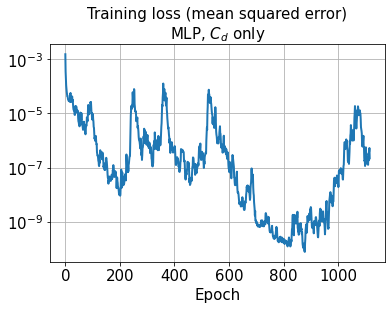

In [39]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

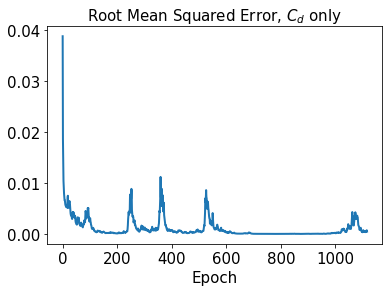

In [40]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

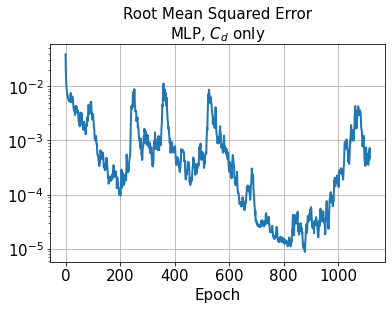

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [42]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 3ms/step - loss: 3.3924e-07 - rmse: 5.8245e-04


In [43]:
test_results = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 2.6837e-06 - rmse: 0.0016


In [44]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

2/2 [==============================] - 0s 2ms/step


In [45]:
model_directory = "D:\\TrainedModels\\20221128"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221128steadyValidation_MLP_test"+str(test_rate)+ "_" + str(n_units) +"units_Cdonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
error_train_abs = np.abs(decoded_train - y_train)

In [47]:
error_test_abs = np.abs(decoded_test - y_test)

In [48]:
os.chdir(storage_dir)

In [49]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.012455119720832629


In [50]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.044301089046860545


In [53]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

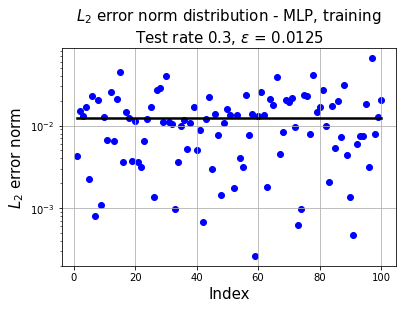

In [55]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

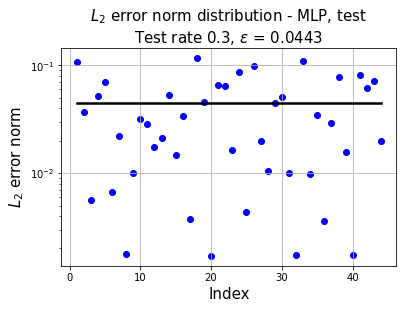

In [56]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [57]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


In [58]:
index_train = np.unique(np.where(np.isin(y, y_train)))
index_test = np.unique(np.where(np.isin(y, y_test)))

In [59]:
iTrain=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
    
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [60]:
iTrain = np.array(iTrain)
iTest = np.array(iTest)

In [61]:
cd

C:\Users\cfdML


In [65]:
alpha

array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
       [16.]])

1/1 [==============================] - 0s 18ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.0161


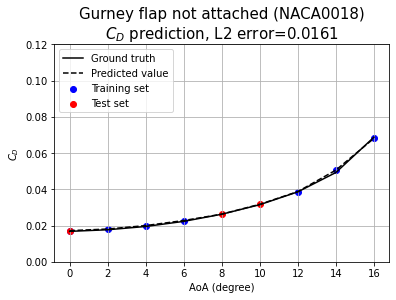

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0162


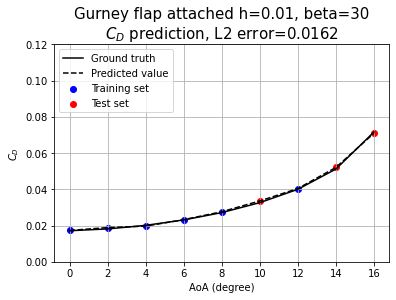

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0155


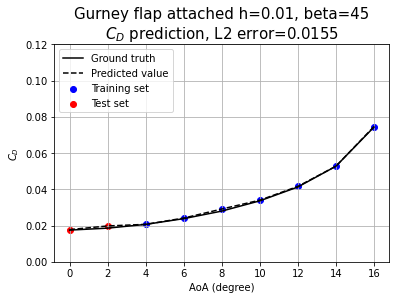

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0366


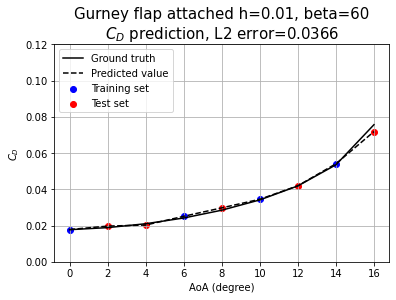

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0349


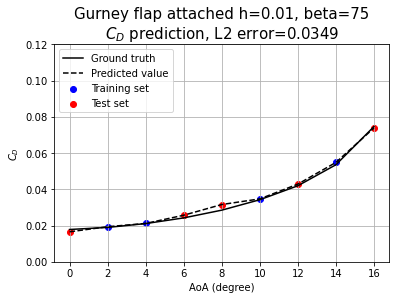

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0496


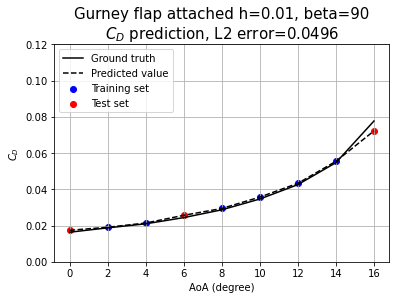

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0075


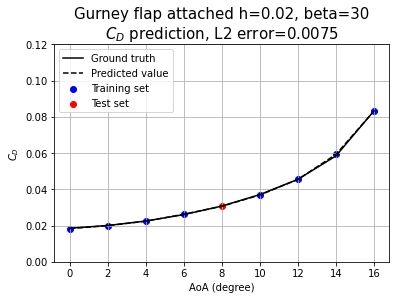

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0112


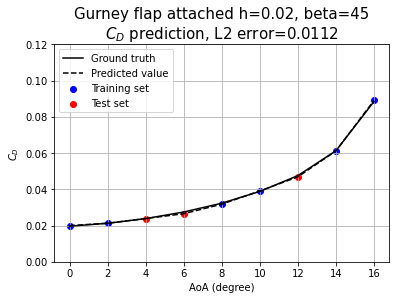

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0107


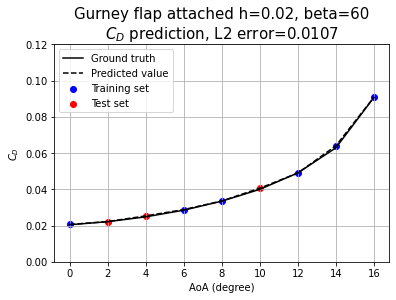

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0199


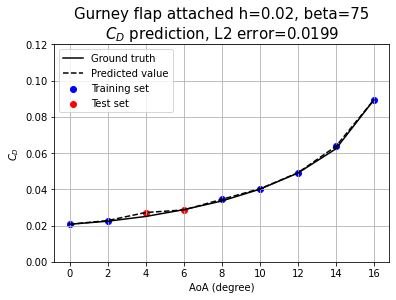

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0346


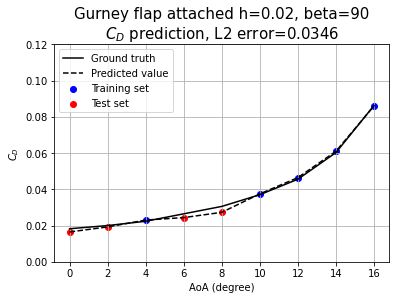

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0098


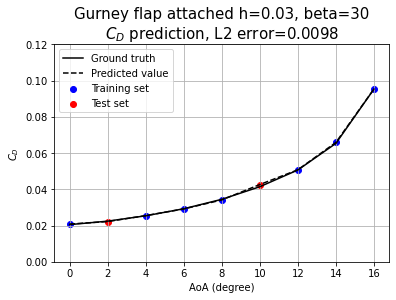

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0103


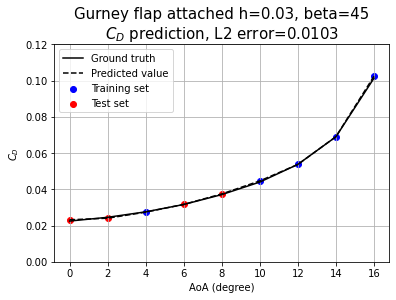

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0141


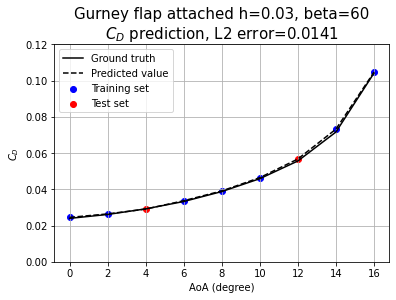

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0263


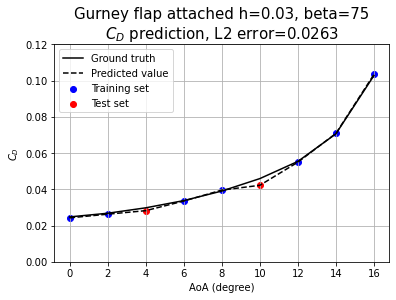

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0309


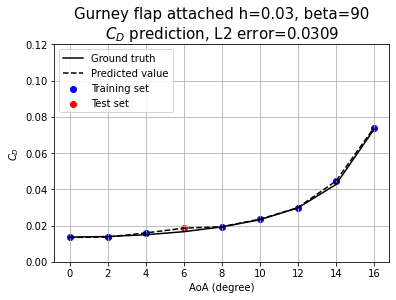

In [66]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    iTrain = []
    iTest = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}'.format(l2_error_Cd))
    else:
        print('L2 error of Cd: {0:0.4f}'.format(l2_error_Cd))
    
    cd = predicted[n_alpha*i:n_alpha*(i+1),0]

    CD = y[n_alpha*i:n_alpha*(i+1),0]
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])

    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)
    iTest = np.array(iTest)
    
    alpha_train = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)[:,0]*max(alpha)
    aTest = np.array(alpha_test)[:,0]*max(alpha)
    
    if i==0:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_NACA0018.jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        
    else:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap attached h=%.2f, beta=%d\n$C_D$ prediction, L2 error=%.4f'%(h[i], beta[i],l2_error_Cd), fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()
